#Pecan validation analysis

Here we perform analysis on the model vs ground truth data for thermal and occupancy consumption. We contrast two models:
* ground truth thermal response: a locally-weighted regression model using separately-monitored HVAC and temperature
* the HMM thermal model

##Initializations

In [2]:
rm(list = ls())
options(error = recover)
library('segmented')
library('lubridate')
library('ggplot2')

In [3]:
setwd("~/EnergyAnalytics/thermal_profiles/")
#source('validator/metrics.r')
source('validator/plot_metrics.r')


Attaching package: ‘reshape’

The following object is masked from ‘package:lubridate’:

    stamp


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [4]:
DATA_PATH = '~/S3L_server/energy-data/pecan_street/usage-select/'
DUMP_PATH = '~/S3L_server/energy-data/pecan_street/models_new/'
PLOT_PATH = '~/S3L_server/plots/pecan-street-new/'
MODEL_PATH= '~/S3L_server/energy-data/pecan_street/models_new/'

Paths to original data

In [5]:
# load user names
user_names = read.csv('~/S3L_server/energy-data/pecan_street/metadata/user_names_ids.csv')
user_names$X = NULL

# list all data files
files    = list.files(path=DATA_PATH, full.names = T, recursive = T)
files_01 = files[grep('01min',files)]
files_15 = files[grep('15min',files)]
files_60 = files[grep('60min',files)]

# extract ID
users_df = data.frame(UID = as.character(sapply(files_60, function(s) strsplit(tail(strsplit(s, '/')[[1]], 1), '\\.')[[1]][1])))
rownames(users_df) = NULL
    
# build original data sources dataframe
users_df = merge(users_df, user_names, by.x="UID", by.y="ID")
users_df['01min'] = files_01
users_df['15min'] = files_15
users_df['60min'] = files_60
users_df = melt(users_df, id=c("UID","name"))
names(users_df)[c(3,4)] = c("grain", "file_orig")  

In [6]:
users_df[1,]

,UID,name,grain,file_orig
1,1069,Edd,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1069.csv


Paths to thermal models data

In [7]:
# models 
files = list.files(path=MODEL_PATH, pattern="*decoded", full.names = T, recursive = T)
model_paths  = lapply(files, function(x) {
    tmp = tail(strsplit(x, '/')[[1]],n=2)
    res = tmp[1]
    nfo = strsplit(tmp[2], "_")[[1]]
    uid = nfo[1]; name = nfo[2]; 
    return(c(uid,name,res,x))
})
model_paths = data.frame(do.call('rbind', model_paths))
if (length(model_paths)>0) names(model_paths) <- c("UID", "name", "grain", "file_model")


In [8]:
head(model_paths)

,UID,name,grain,file_model
1,114,James,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//114_James/15min/114_James_decoded.RData
2,114,James,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//114_James/60min/114_James_decoded.RData
3,22,Christian,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//22_Christian/15min/22_Christian_decoded.RData
4,26,Carl,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//26_Carl/15min/26_Carl_decoded.RData
5,26,Carl,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//26_Carl/60min/26_Carl_decoded.RData
6,48,Abner,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//48_Abner/15min/48_Abner_decoded.RData


In [9]:
info_files = merge(model_paths, users_df, by=c("UID", "name", "grain"))
info_files = info_files[with(info_files, order(UID,grain,name)),]

In [10]:
dim(info_files); dim(model_paths); dim(users_df)

[1] 15  5

[1] 15  4

[1] 1098    4

In [11]:
head(info_files)

,UID,name,grain,file_model,file_orig
1,114,James,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//114_James/15min/114_James_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/114.csv
2,114,James,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//114_James/60min/114_James_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/114.csv
3,22,Christian,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//22_Christian/15min/22_Christian_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/22.csv
4,26,Carl,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//26_Carl/15min/26_Carl_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/26.csv
5,26,Carl,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//26_Carl/60min/26_Carl_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/26.csv
6,48,Abner,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//48_Abner/15min/48_Abner_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/48.csv


##Load processed thermal regimes data

In [12]:
thermal_lst = list()
for (i in 1:nrow(info_files)) {
    print(paste("Processing file", i, "of", nrow(info_files)))
    row <- info_files[i,]
    load(as.character(as.character(row$file_model)));
    df = data$df
    
    if (nrow(data$states) != nrow(df)) next
        
    # access data    
    nStates= data$nStates
    df$state = data$states; 
    df$TemperatureD = df$TemperatureF - 65
    resp   = data$response   
    tran   = data$transition
    tran   = lapply(unique(tran$From), function(s) {d = subset(tran, To ==s); d$From = d$To = NULL; rownames(d) = 1:nrow(d); return(d)})

    # check for consistency
    if (class(resp$stderr) == 'list') {
      idx.nan = which(sapply(resp$stderr, length) < 2)    
      z = c(0,0,0); names(z) = c('(Intercept)', 'TemperatureD')
      for (i in 1:length(idx.nan)) {
        tmp = resp$stderr[[idx.nan[i]]]
        z[names(tmp)] = tmp
        resp$stderr[[idx.nan[i]]] = z
      }
      resp$stderr = as.data.frame(do.call('cbind', resp$stderr))
      names(resp$stderr) = 1:ncol(resp$stderr)
    }

    # format model parameters for easy analysis access
    volatility = lapply(1:nStates, function(s) { z = c(mu = 0, sd = resp$stdev[s]); names(z) = c('mu', 'sd'); z})
    baseload   = lapply(1:nStates, function(s) { z = c(mu = resp$means['(Intercept)', s], sd = resp$stderr['(Intercept)', s]); names(z) = c('mu', 'sd'); z})
    response   = lapply(1:nStates, function(s) c(mu = resp$means['TemperatureD', s], sd = as.numeric(resp$stderr['TemperatureD', s])))

    thermal_lst[[as.character(row$name)]][[as.character(row$grain)]] = list(volatility = volatility, baseload = baseload, response = response, tran = tran, data = df)
}

[1] "Processing file 1 of 15"
[1] "Processing file 2 of 15"
[1] "Processing file 3 of 15"
[1] "Processing file 4 of 15"
[1] "Processing file 5 of 15"
[1] "Processing file 6 of 15"
[1] "Processing file 7 of 15"
[1] "Processing file 8 of 15"
[1] "Processing file 9 of 15"
[1] "Processing file 10 of 15"
[1] "Processing file 11 of 15"
[1] "Processing file 12 of 15"
[1] "Processing file 13 of 15"
[1] "Processing file 14 of 15"
[1] "Processing file 15 of 15"


In [13]:
head(data$states)

,state,X1,X2,X3,X4,fit,fit.max
1,3,0.5389822,0,0.4610178,0,0.8323189,1.118036
2,3,0.1021138,1.240933e-18,0.8978862,4.083677e-55,1.065619,1.119901
3,3,0.006385416,3.156041e-22,0.9936146,1.100864e-62,1.113796,1.117177
4,1,0.571994,6.160103e-07,0.4280054,6.999561e-26,0.8124221,0.5870254
5,1,0.9218506,0.0004733498,0.07767603,3.628078e-17,0.6271661,0.5865177
6,1,0.9862952,0.001374905,0.01232992,9.532188e-16,0.5921387,0.5860012


In [14]:
dim(data$states); dim(df)

[1] 12065     7

[1] 12065     5

##Estimate "ground truth" thermal response

In [22]:
info_files[5,]

,UID,name,grain,file_model,file_orig
5,26,Carl,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//26_Carl/60min/26_Carl_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/26.csv


In [23]:
# format data to match the observations available for thermal modeling
row <- info_files[5,]
df = read.csv(as.character(row$file_orig))
df$HVAC = df$HV + df$AC
df$TemperatureD = df$TemperatureF - 65

In [24]:
dim(df)

[1] 12352    10

In [25]:
fit = loess(HVAC ~ TemperatureD, data=df)
plx = predict(fit, se=T)

In [26]:
str(plx)

List of 4
 $ fit           : Named num [1:12352] 0.0668 0.0835 0.0413 0.0301 0.0457 ...
  ..- attr(*, "names")= chr [1:12352] "1" "2" "3" "4" ...
 $ se.fit        : Named num [1:12352] 0.00876 0.00857 0.00862 0.00852 0.00869 ...
  ..- attr(*, "names")= chr [1:12352] "1" "2" "3" "4" ...
 $ residual.scale: num 0.52
 $ df            : num 12347


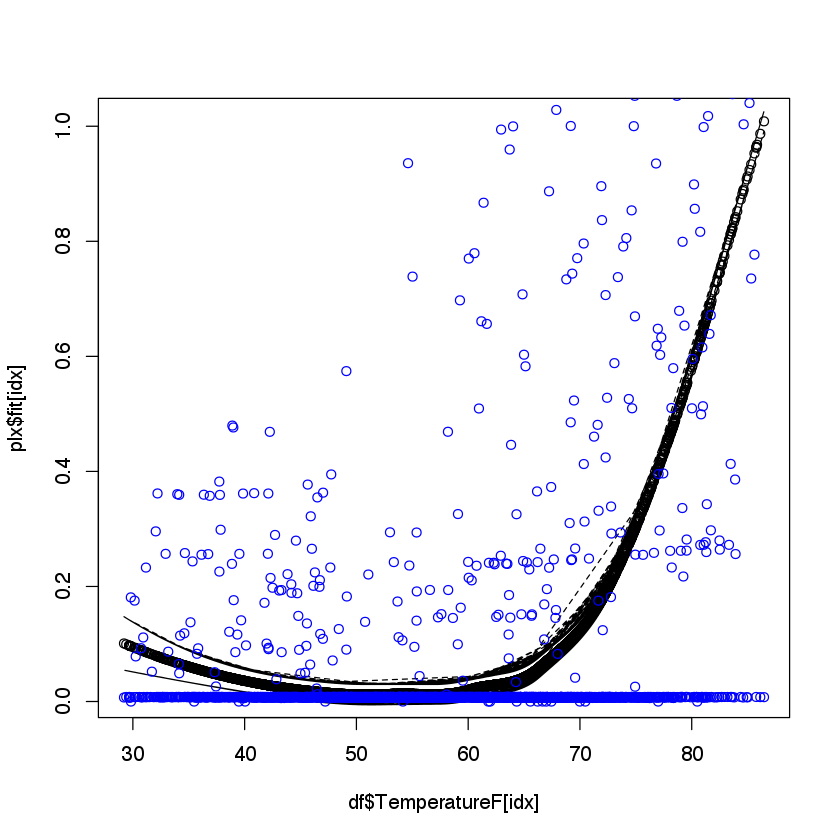

In [38]:

idx = 1:3000
plot(df$TemperatureF[idx],plx$fit[idx])
lines(df$TemperatureF[idx],plx$fit[idx]+2*plx$s[idx], lty=2) #rough & ready CI
lines(df$TemperatureF[idx],plx$fit[idx]-2*plx$s[idx], lty=2)
points(df$TemperatureF[idx], df$HVAC[idx], col='blue')

In [19]:
# plx
# dff = subset(df, AC>0)
# plot(dff$TemperatureF, dff$AC)
# lines(lowess(dff$TemperatureF, dff$AC), col = 2)